# Machine Learning & Content Analytics Project

## **Smart Article Annotator & Recommender System**

---


**Alfa** team



> Petros Tsotsi <br />
> Academic ID: f2822412 <br />


> Thanasis Zygokostas <br />
> Academic ID: f2822402 <br />



> Michalis Athanasiou <br />
> Academic ID: f2822401 <br />

---

The present notebook implements the **Text Annotation task** of our project "Smart Article Annotator & Recommender System"

--------------------------------------------------------------------------------------------------------------------------------------------------------

* We start with importing some basic necessary libraries:

In [ ]:
import os
import pandas as pd
import numpy as np
import ast
from collections import Counter
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm

--------------------------------------------------------------------------------------------------------------------------------------------------------

## **Data Loading**

2 alternatives:
* (When in Colab) Load data through Kaggle or
* (When in Jupyter) Load data from local csv file

**1st Alternative** (when in Colab): Load data through Kaggle

In [ ]:
import kagglehub

download_path = kagglehub.dataset_download("fabiochiusano/medium-articles")
dataset_path = os.path.join(download_path, "medium_articles.csv")

df = pd.read_csv(dataset_path)

print(df.head())

Using Colab cache for faster access to the 'medium-articles' dataset.
                              title  \
0               Mental Note Vol. 24   
1         Your Brain On Coronavirus   
2                    Mind Your Nose   
3          The 4 Purposes of Dreams   
4  Surviving a Rod Through the Head   

                                                text  \
0  Photo by Josh Riemer on Unsplash\n\nMerry Chri...   
1  Your Brain On Coronavirus\n\nA guide to the cu...   
2  Mind Your Nose\n\nHow smell training can chang...   
3  Passionate about the synergy between science a...   
4  You’ve heard of him, haven’t you? Phineas Gage...   

                                                 url                 authors  \
0  https://medium.com/invisible-illness/mental-no...            ['Ryan Fan']   
1  https://medium.com/age-of-awareness/how-the-pa...       ['Simon Spichak']   
2  https://medium.com/neodotlife/mind-your-nose-f...                      []   
3  https://medium.com/science-for-real

**2nd Alternative** (when in Jupyter): Load data from local csv file

In [ ]:
df = pd.read_csv("medium_articles.csv")

--------------------------------------------------------------------------------------------------------------------------------------------------------

## **Data Preprocessing**



* Check the shape of the data

In [ ]:
print(df.shape)

(192368, 6)


* Keep only text and tags of the articles

In [ ]:
df = df[['text','tags']]

* Explore the most popular tags (top 30)

In [ ]:
df["tags"] = df["tags"].apply(ast.literal_eval)   # turn tags to list of tags

all_tags = [tag for tags in df["tags"] for tag in tags]  # find all available tags

tag_counts = Counter(all_tags)        # find the frequency of the tags
top_tags = tag_counts.most_common(30) # and keep the 30 most frequent tags
top_tags

[('Blockchain', 7534),
 ('Data Science', 7410),
 ('Technology', 6384),
 ('Programming', 6364),
 ('Poetry', 6336),
 ('Cryptocurrency', 6245),
 ('Machine Learning', 6055),
 ('Life', 5954),
 ('Bitcoin', 5800),
 ('Writing', 5115),
 ('Politics', 5074),
 ('Startup', 4974),
 ('Life Lessons', 4807),
 ('Self Improvement', 4267),
 ('Covid 19', 4176),
 ('Software Development', 3980),
 ('Love', 3978),
 ('Python', 3943),
 ('Business', 3722),
 ('Health', 3650),
 ('Mental Health', 3583),
 ('JavaScript', 3487),
 ('Relationships', 3377),
 ('Education', 3269),
 ('Artificial Intelligence', 3222),
 ('Culture', 3027),
 ('Design', 2932),
 ('Self', 2876),
 ('Marketing', 2791),
 ('Entrepreneurship', 2782)]

* Filter the data so that we keep only the top 30 tags for each article

In [ ]:
top_tag_names, top_tag_counts = zip(*top_tags)

def filter_tags(tags):
    return [tag for tag in tags if tag in top_tag_names]

df["tags"] = df["tags"].apply(filter_tags)

* and keep only those articles having at least one of the top 30 tags

In [ ]:
df = df[df["tags"].apply(lambda tags: len(tags) > 0)]
df

,text,tags
0,Photo by Josh Riemer on Unsplash\n\nMerry Chri...,"[Mental Health, Health]"
1,Your Brain On Coronavirus\n\nA guide to the cu...,[Mental Health]
3,Passionate about the synergy between science a...,"[Health, Mental Health]"
4,"You’ve heard of him, haven’t you? Phineas Gage...",[Health]
5,"Mentally, Young Adults Are Suffering Most From...","[Mental Health, Health]"
...,...,...
192333,[Live Stream] 2021 Soul Train Music Awards | F...,[Technology]
192336,Photo by Comeup 2021 on Comeup 2021\n\nThe glo...,[Startup]
192340,How To Deal with Loneliness in Festivals & Exp...,[Life Lessons]
192342,"Type 2 diabetes is on the rise globally, and h...",[Health]


* Then, we consider as X the articles text:

In [ ]:
X = df.text
X

,text
0,Photo by Josh Riemer on Unsplash\n\nMerry Chri...
1,Your Brain On Coronavirus\n\nA guide to the cu...
3,Passionate about the synergy between science a...
4,"You’ve heard of him, haven’t you? Phineas Gage..."
5,"Mentally, Young Adults Are Suffering Most From..."
...,...
192333,[Live Stream] 2021 Soul Train Music Awards | F...
192336,Photo by Comeup 2021 on Comeup 2021\n\nThe glo...
192340,How To Deal with Loneliness in Festivals & Exp...
192342,"Type 2 diabetes is on the rise globally, and h..."


* And as y (target) the article tags:

In [ ]:
y = df.tags
y

,tags
0,"[Mental Health, Health]"
1,[Mental Health]
3,"[Health, Mental Health]"
4,[Health]
5,"[Mental Health, Health]"
...,...
192333,[Technology]
192336,[Startup]
192340,[Life Lessons]
192342,[Health]


--------------------------------------------------------------------------------------------------------------------------------------------------------

## **Data Analysis & Visualization**

### **Articles Text Length Distribution**

* We show, through a histogram, the Average Text Length (in words) of the dataset article texts

In [ ]:
df["text_word_count"] = df["text"].str.split().apply(len)


fig = px.histogram(df[df["text_word_count"] <= 4000],
                   x="text_word_count",
                   width=900,
                    height=500)

fig.update_layout(
    title = 'Distribution of Articles Text Length',
    xaxis_title="Text Length (in words)",
    yaxis_title="Frequency"
)
fig.show()

df.drop("text_word_count", axis=1, inplace=True)

### **Number of Tags per Article**

* Now we show the Distribution of the number of Tags/Labels per article in our dataset

/tmp/ipython-input-1503338721.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




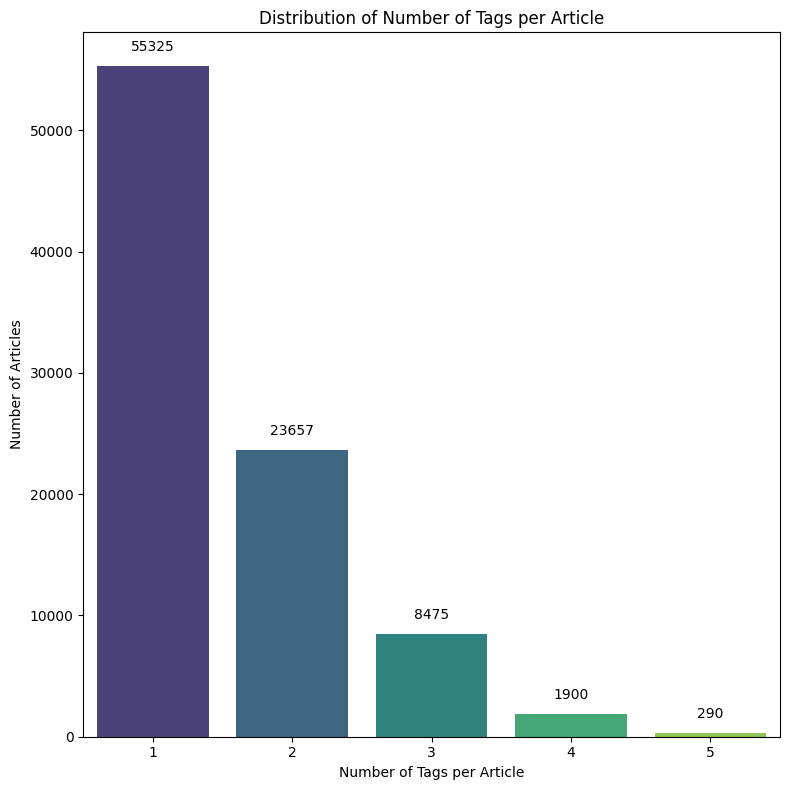

In [ ]:
import seaborn as sns


count_of_tags = df['tags'].apply(len)

# Calculate distribution
tag_count_distribution = count_of_tags.value_counts().sort_index()

# Create vertical barplot
plt.figure(figsize=(8, 8))
ax = sns.barplot(
    x=tag_count_distribution.index,
    y=tag_count_distribution.values,
    palette="viridis"
)

# Add value labels on top of bars
for bar in ax.patches:
    height = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2
    ax.text(x, height + 1000, f'{int(height)}', ha='center', va='bottom')

# Labels and title
ax.set_xlabel("Number of Tags per Article")
ax.set_ylabel("Number of Articles")
ax.set_title("Distribution of Number of Tags per Article")
plt.tight_layout()
plt.show()


### **Most Frequent Tags**

* The following barplot visualizes the most common (top 30) tags appearing in our articles dataset

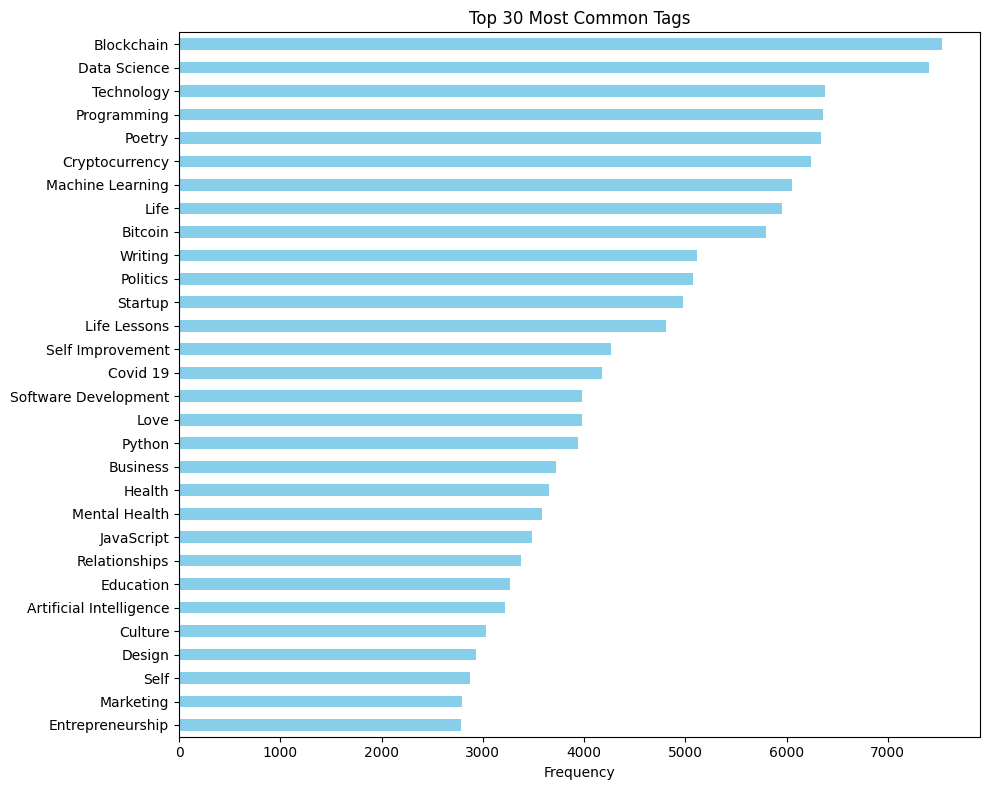

In [ ]:
# Convert tag_counts to a Series and sort
tag_series = pd.Series(tag_counts).sort_values(ascending=True).tail(30)

# Plot as horizontal bar chart


tag_series.plot(kind='barh', figsize=(10, 8), color = 'skyblue')
plt.title("Top 30 Most Common Tags")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

### **Average Word Count per Tag**

* In this barplot we visualize the Average Text Length (number of words) for the articles of each topic category

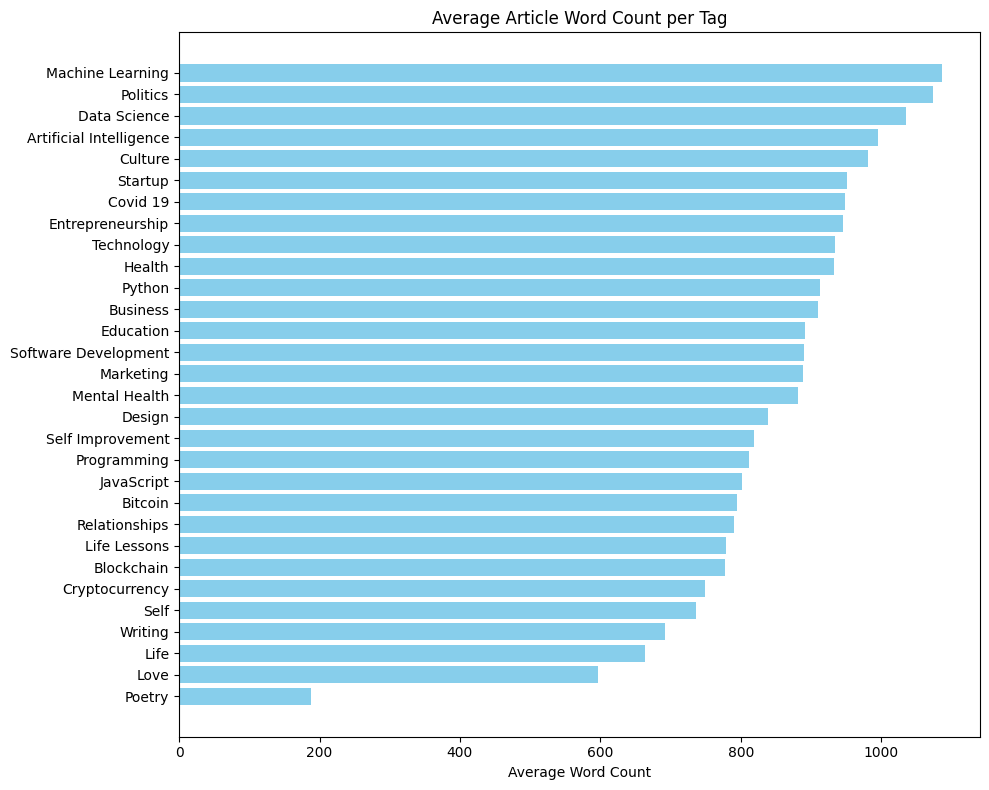

In [ ]:
df["text_word_count"] = df["text"].str.split().apply(len)


avg_word_counts = {}

for tag in top_tag_names:
    tagged_texts = df[df["tags"].apply(lambda tags: tag in tags)]
    avg_words = tagged_texts["text_word_count"].mean()
    avg_word_counts[tag] = avg_words


avg_word_counts_df = pd.DataFrame.from_dict(avg_word_counts, orient='index', columns=["avg_word_count"])
avg_word_counts_df = avg_word_counts_df.sort_values(by="avg_word_count", ascending=False)

avg_word_counts_df = avg_word_counts_df.reset_index()
avg_word_counts_df.rename(columns={'index': 'tag'}, inplace=True)

plt.figure(figsize=(10, 8))
plt.barh(avg_word_counts_df['tag'], avg_word_counts_df['avg_word_count'], color='skyblue')
plt.xlabel('Average Word Count')
plt.title('Average Article Word Count per Tag')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

df.drop('text_word_count', axis=1, inplace=True)  # remove added column


### **WordCloud Plot**

* This WordCloud plot simply illustrates the most popular tags by showing their names in a single plot

Text(0.5, 1.0, 'Article Topics Popularity')

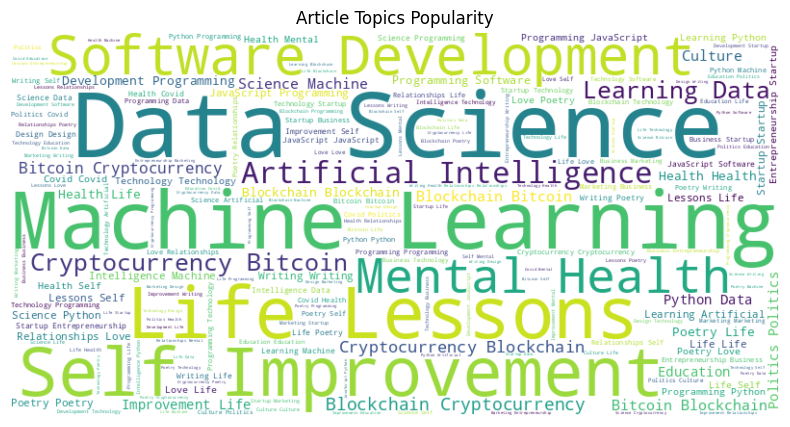

In [ ]:
from wordcloud import WordCloud

all_tags = [tag for tags in df["tags"] for tag in tags]
tag_text = ' '.join(all_tags)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tag_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Article Topics Popularity")

### **Most Usual Words per Tag**

* We firstly calculate the most appearing words in the articles of each tag category along with their frequencies (Output suppressed)

In [ ]:
import nltk
from nltk.corpus import stopwords


nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

custom_stopwords = {"like", "one"}
stop_words.update(custom_stopwords)

most_common_word_per_tag = {}


for tag in top_tag_names:

    texts = df[df["tags"].apply(lambda tags: tag in tags)]["text"]


    all_words = ' '.join(texts).lower().split()
    filtered_words = [word for word in all_words if word.isalpha() and word not in stop_words]


    word_counts = Counter(filtered_words)

    most_common = word_counts.most_common(5)
    most_common_word_per_tag[tag] = most_common



for tag, word_counts in most_common_word_per_tag.items():
    print(f"{tag}:")
    for word, count in word_counts:
        print(f"  '{word}': {count}")


* And next we plot in separate barplots for each tag, the most frequently appearing words

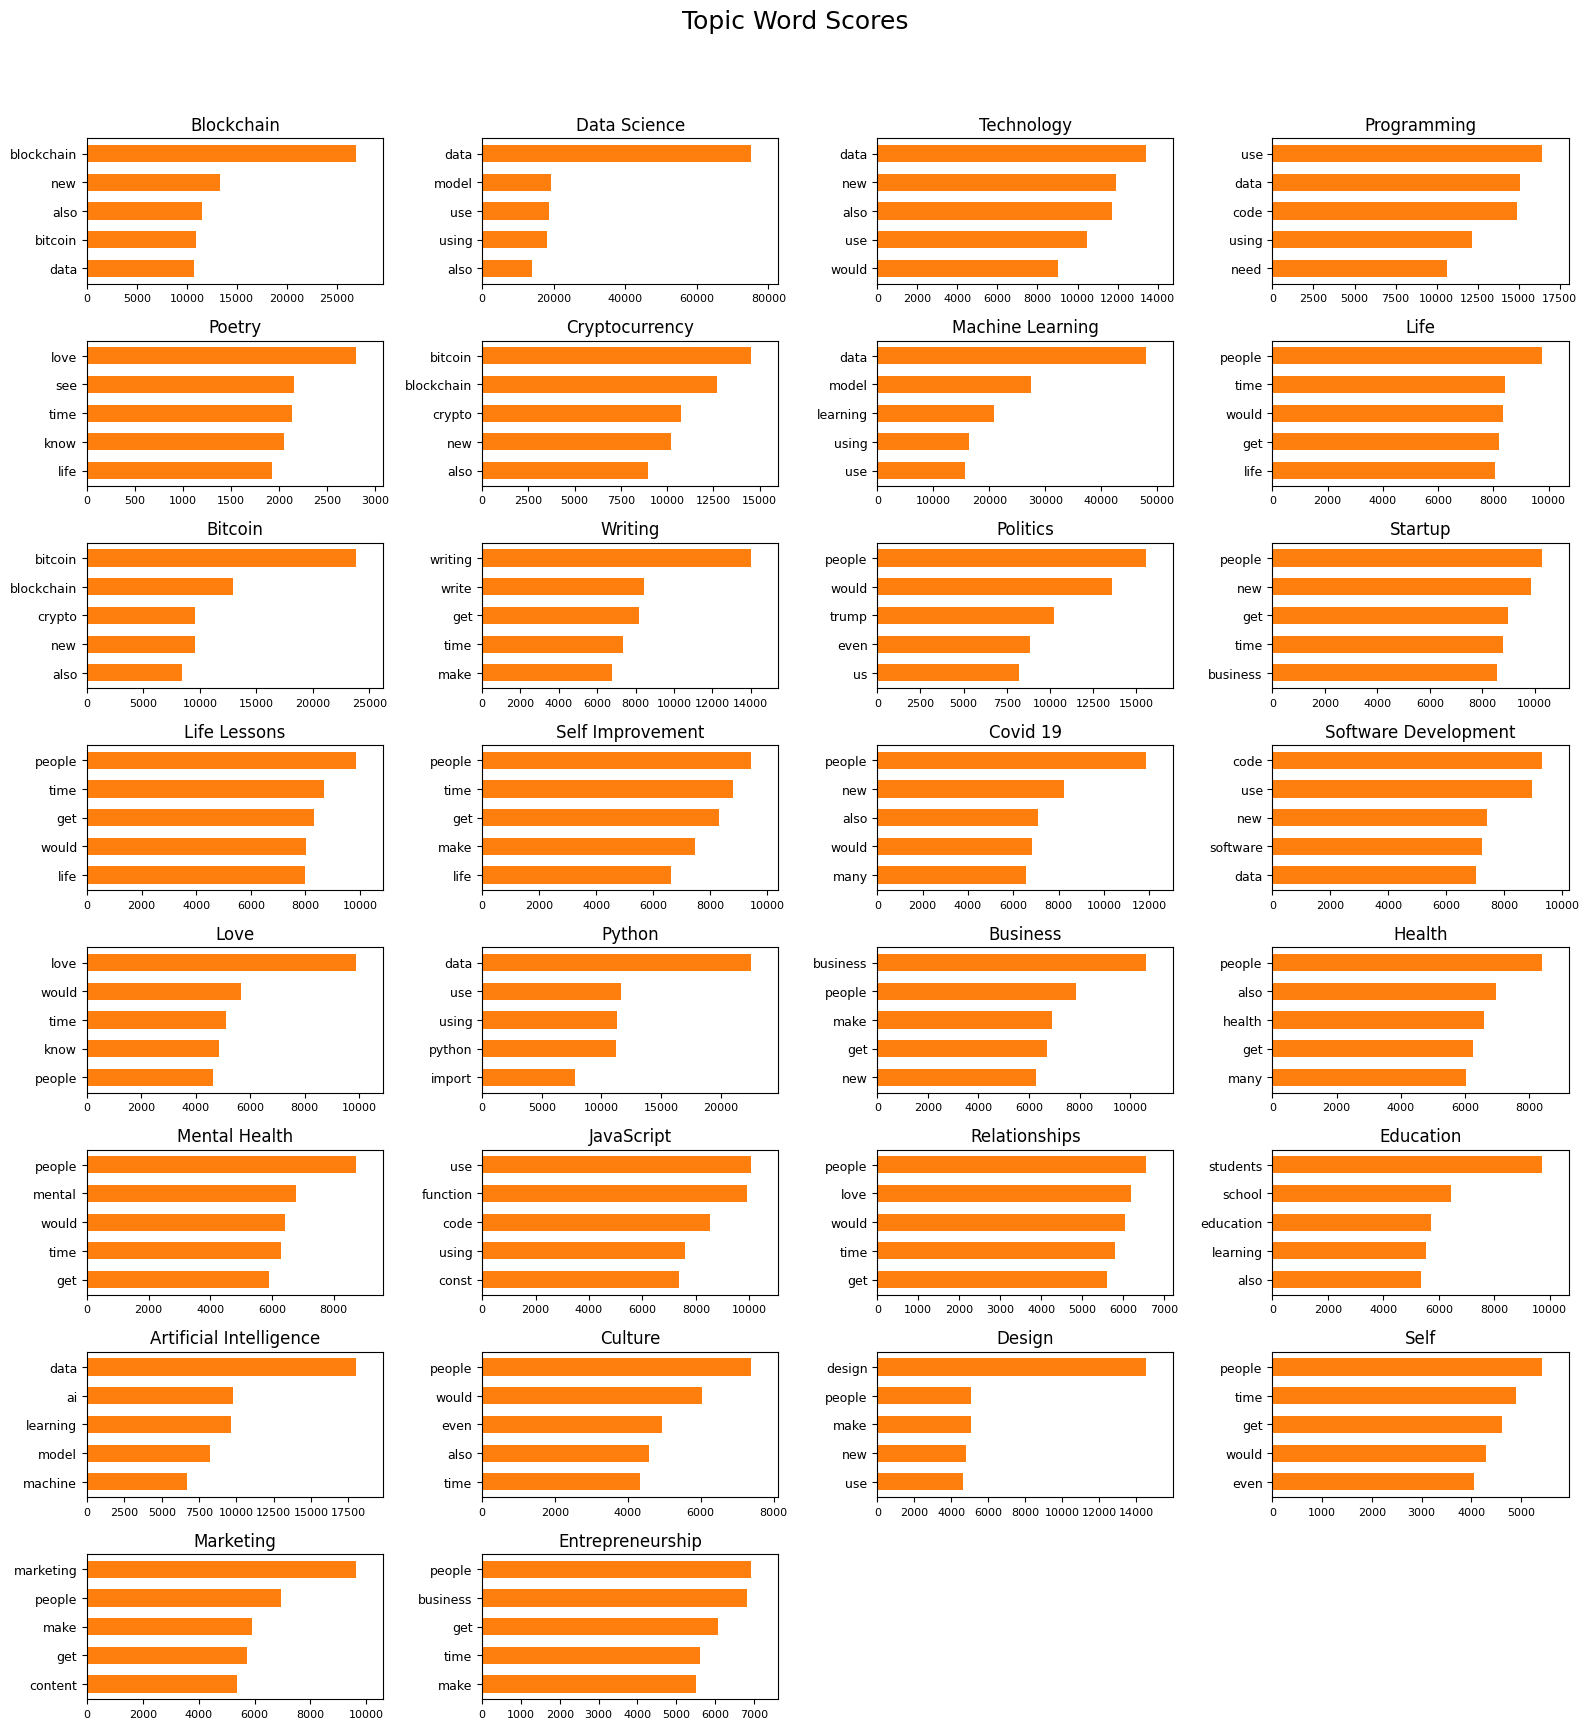

In [ ]:
import matplotlib.pyplot as plt

topics = most_common_word_per_tag

num_topics = len(topics)
cols = 4
rows = (num_topics + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 2.2))
fig.suptitle("Topic Word Scores", fontsize=18)

for i, (topic, word_scores) in enumerate(topics.items()):
    ax = axes.flat[i]
    words, counts = zip(*word_scores)

    ax.barh(words[::-1], counts[::-1], height=0.6, color='tab:orange')
    ax.set_title(topic, fontsize=12)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=9)
    ax.set_xlim(0, max(counts) * 1.1)

    ax.set_xlabel('')
    ax.set_ylabel('')

for j in range(i + 1, rows * cols):
    fig.delaxes(axes.flat[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


--------------------------------------------------------------------------------------------------------------------------------------------------------

## **Splitting Dataset Procedure**

Before getting to our models, we need to split our data into 3 subsets (train, validation, test).

For the splitting process we use a random split way instead of a stratified splitting since we have a **multilabel classification problem** and stratification cannot be practically achieved.

* By making use of **train_test_split** method of sklearn, we split the data to keep a random 15% as test dataset.

In [ ]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X,
                                                            y,
                                                            test_size=0.15,
                                                            random_state=42)

* Then, by using again the **train_test_split** method we split the rest 85% of the data to 20% for validation and to 80% for training.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.20,
                                                  random_state=42)

* Now we can check the relevant shapes of the 3 subsets:

In [ ]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print()

print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')

print()
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (60959,)
y_train shape: (60959,)

X_val shape: (15240,)
y_val shape: (15240,)

X_test shape: (13448,)
y_test shape: (13448,)


* And we can plot the dataset split distribution into these 3 subsets:

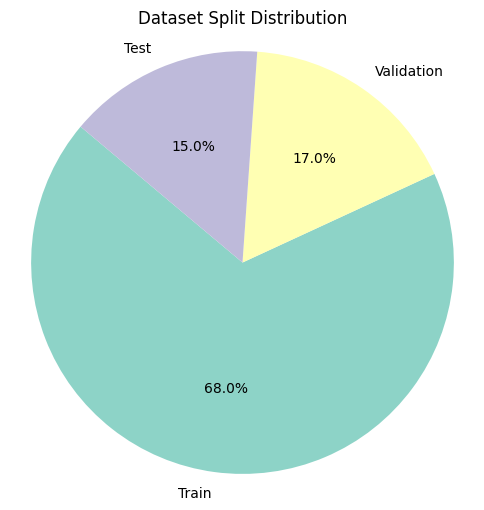

In [ ]:
import matplotlib.pyplot as plt

sizes = [X_train.shape[0], X_val.shape[0], X_test.shape[0]]
labels = ['Train', 'Validation', 'Test']
colors = ['#8dd3c7', '#ffffb3', '#bebada']




# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Dataset Split Distribution')
plt.axis('equal')
plt.show()


* Before proceeding to the next tasks, we reset the index of the newly created subsets which because of the random splitting appear shuffled:

In [ ]:
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

--------------------------------------------------------------------------------------------------------------------------------------------------------

## **Articles Text Encoding**

In this step of the project, we will conduct the encoding of the articles text. During this process we will convert the text of each article to a numeric vector that can be given as input to the models that will use in the next steps.

In [ ]:
import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

* We firstly initialize the **Keras Tokenizer** for the articles text encoding (with max_words = 20.000)

In [ ]:
max_words = 20_000  # We will only consider the 20K most used words in this dataset

# Setting up Keras tokenizer
articles_tokenizer = Tokenizer(num_words=max_words, lower=True, oov_token='<OOV>')
articles_tokenizer

* We proceed with fitting the tokenizer **ONLY** in the Training dataset articles

In [ ]:
articles_tokenizer.fit_on_texts(X_train)

* And next we apply the tokenizer to all 3 dataset articles (Train, Val, Test)

In [ ]:
X_train = articles_tokenizer.texts_to_sequences(X_train)

X_val = articles_tokenizer.texts_to_sequences(X_val)

X_test = articles_tokenizer.texts_to_sequences(X_test)

* Furthermore, we apply padding to all encoded article texts with a max length equal to 300

In [ ]:
maxlen = 300

X_train = pad_sequences(X_train, maxlen=maxlen)

X_val = pad_sequences(X_val, maxlen=maxlen)

X_test = pad_sequences(X_test, maxlen=maxlen)

* Finally, we can check the shapes of the encoded article texts of each subset:

In [ ]:
print('Train data shape: {}'.format(X_train.shape))

print('Validation data shape: {}'.format(X_val.shape))

print('Test data shape: {}'.format(X_test.shape))

Train data shape: (60959, 300)
Validation data shape: (15240, 300)
Test data shape: (13448, 300)


--------------------------------------------------------------------------------------------------------------------------------------------------------

## **Articles Tags Encoding**

In this step of the project we will conduct the encoding of the article tags. Given the article tags which are in the form of a list, we will transform them into numeric vectors of length 30 (equal to the total number of tag categories we have) where each index corresponds to a specific tag-category. The produced vector will have value 1 on those indexes that correspond to the matched categories, and 0 to the rest.

* As we can see the tags of our articles are in the following form:

In [ ]:
y_train

,tags
0,"[Life Lessons, Self Improvement, Life, Self]"
1,[Culture]
2,[Education]
3,[Self Improvement]
4,[Business]
...,...
60954,[Artificial Intelligence]
60955,[Politics]
60956,[Technology]
60957,"[Artificial Intelligence, Bitcoin, Cryptocurre..."


* We start with initializing the **MultiLabel Binarizer** of sklearn, which is suitable for our problem where each article can have multiple tags

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

* After that, we fit and apply the binarizer **ONLY** on the Training dataset tags

In [ ]:
y_train_encoded = mlb.fit_transform(y_train)

* And next we apply it to transform the tags of the other 2 datasets (Validation & Test)

In [ ]:
y_val_encoded = mlb.transform(y_val)
y_test_encoded = mlb.transform(y_test)

* Finally, we can check the resulting encoding by looking at the identified classes:

In [ ]:
print(mlb.classes_)

['Artificial Intelligence' 'Bitcoin' 'Blockchain' 'Business' 'Covid 19'
 'Cryptocurrency' 'Culture' 'Data Science' 'Design' 'Education'
 'Entrepreneurship' 'Health' 'JavaScript' 'Life' 'Life Lessons' 'Love'
 'Machine Learning' 'Marketing' 'Mental Health' 'Poetry' 'Politics'
 'Programming' 'Python' 'Relationships' 'Self' 'Self Improvement'
 'Software Development' 'Startup' 'Technology' 'Writing']


* And also by checking a random article example and how its labels have been encoded.

For the following example we can see that it has 4 distinct tags:

In [ ]:
y_train[0]

['Life Lessons', 'Self Improvement', 'Life', 'Self']

* And when encoded with the above method, it is converted to a vector (1x30) having 4 ones at the positions corresponding to its tags:

In [ ]:
y_train_encoded[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0])

* And in the end we can also check the shapes of the encoded article tags of each subset:

In [ ]:
print('Train tags shape: {}'.format(y_train_encoded.shape))

print('Validation tags shape: {}'.format(y_val_encoded.shape))

print('Test tags shape: {}'.format(y_test_encoded.shape))

Train tags shape: (60959, 30)
Validation tags shape: (15240, 30)
Test tags shape: (13448, 30)


--------------------------------------------------------------------------------

## **Modeling**

* The Modeling phase begins with the import of some necessary libraries for our models:

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    Embedding,
    LSTM,
    Input,
    Concatenate,
    Bidirectional,
    Dropout,
    concatenate
)
from tensorflow.keras.metrics import AUC, Precision, Recall
from sklearn.metrics import confusion_matrix, classification_report

* We set also the following parameters of our models' training at the following steps:

In [ ]:
maxlen = 300 # is set during padding

max_words = 20_000 # is set in Tokenizer

epochs = 30

batch_size = 128

embedding_dim = 300

* Additionally, we set the following Callbacks to be used during the models' training:

In [ ]:
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    ReduceLROnPlateau,
    EarlyStopping
)

# monitor quantity is val_loss
monitor = 'val_loss'

# Stop training when a monitored quantity has stopped improving
early_stopping_callback = EarlyStopping(monitor=monitor,
                                        patience=3,
                                        verbose=1,
                                        restore_best_weights=True)

# Reduce learning rate when a metric has stopped improving
reduce_lr_callback = ReduceLROnPlateau(monitor=monitor,
                                       factor=0.1,
                                       patience=3,
                                       verbose=1)


# callbacks for the Sequential model

seq_model_callbacks = [

    early_stopping_callback,

    reduce_lr_callback,

    # Save the model after every epoch of the monitor quantity improves
    ModelCheckpoint(filepath='seq_model.keras',
                    monitor=monitor,
                    save_best_only=True,
                    save_weights_only=False,
                    verbose=1),
]


# callbacks for the LSTM model

lstm_model_callbacks = [

    early_stopping_callback,

    reduce_lr_callback,

    # Save the model after every epoch of the monitor quantity improves
    ModelCheckpoint(filepath='lstm_model.keras',
                    monitor=monitor,
                    save_best_only=True,
                    save_weights_only=False,
                    verbose=1)
]

Furthermore as a preparatory step of the models development, we will proceed with creating an embedding matrix made of the pretrained **Glove embeddings**.

* At first we will download the Glove embeddings (of size 300) from Kaggle:

In [ ]:
glovedataset_path = kagglehub.dataset_download('palakurthidurga/glovedataset')
glovedataset_path = os.path.join(glovedataset_path, "glove.42B.300d.txt")
print(glovedataset_path)

100%|██████████| 1.80G/1.80G [00:27<00:00, 70.4MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/palakurthidurga/glovedataset/versions/1/glove.42B.300d.txt


* Next, we define the **load_glove_embeddings** function (taken by the lab code) which loads the Glove embeddings:

In [ ]:
def load_glove_embeddings(path, dim: int = 300) -> dict:
    """
    Function that loads glove embeddings.

    :param dim: The embeddings size (dimensions)
    :return:
    """
    print('Loading word vectors')

    embed_index = dict()  # We create a dictionary of word -> embedding

    #fname = '/kaggle/input/glovedataset/glove.42B.300d.txt'

    f = open(path, encoding="utf8")  # Open file

    # In the dataset, each line represents a new word embedding
    # The line starts with the word and the embedding values follow
    for line in tqdm(f, desc='Loading Embeddings', unit='word'):
        values = line.split()
        # The first value is the word, the rest are the values of the embedding
        word = values[0]
        # Load embedding
        embedding = np.asarray(values[1:], dtype='float32')

        # Add embedding to our embedding dictionary
        embed_index[word] = embedding
    f.close()

    print('Found %s word vectors.' % len(embed_index))

    return embed_index

* And call the function to perform the load of the Glove embdeddings:

In [ ]:
embeddings_index = load_glove_embeddings(path = glovedataset_path, dim=embedding_dim)

Loading word vectors


Loading Embeddings: 1917495word [02:41, 11836.84word/s]

Found 1917495 word vectors.


* Finally, we also define the **create_embeddings_matrix** function (taken by the lab code) which creates the embedding matrix made by the loaded Glove embeddings, and which can be used by our models.

In [ ]:
def create_embeddings_matrix(emb_index: dict,
                             tokenizer: Tokenizer,
                             emb_dim: int = 300) -> np.ndarray:
    """

    :param emb_index: Embeddings Index
    :param tokenizer: Keras fitted tokenizer.
    :param emb_dim: Embeddings dimension.
    :return: A matrix of shape (nb_words, emb_dim) containing the globe embeddings.
    """
    assert emb_dim in [50, 100, 200, 300]

    # Create a matrix of all embeddings
    # (stacking=concatenating all the vectors)
    all_embs = np.stack(list(emb_index.values()))  # .values() gets the all the arrays from the keys

    # Calculate mean
    emb_mean = all_embs.mean()
    # Calculate standard deviation
    emb_std = all_embs.std()

    print("Embeddings AVG: {} | STD: {}".format(emb_mean, emb_std))

    # We can now create an embedding matrix holding all word vectors.

    word_index = tokenizer.word_index

    # How many words are there actually. Because we may have requested X most common tokens
    # and the total tokens are X/2
    nb_words = min(max_words, len(word_index))

    # Create a random matrix with the same mean and std as the embeddings

    embedding_matrix = np.random.normal(emb_mean,  # mean
                                        emb_std,  # std
                                        (nb_words, emb_dim)) # shape of the matrix

    # The vectors need to be in the same position as their index.
    # Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on

    counter = 0

    # Loop over all words in the word index
    for word, i in word_index.items():  # .items() return a tuple with (word, word_index)

        # If we are above the amount of words we want to use we do nothing
        if i >= max_words:
            continue

        # Get the embedding vector for the word
        embedding_vector = emb_index.get(word)

        # If there is an embedding vector, put it in the embedding matrix
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            counter += 1

    print(f'Found {counter} pre-trained embeddings out of {nb_words}')

    return embedding_matrix

* By calling the function, we create the embedding matrix made by the Glove embeddings. This embedding matrix will be used in the construction of our models next.

In [ ]:
embedding_matrix = create_embeddings_matrix(emb_index=embeddings_index,
                                            tokenizer=articles_tokenizer,
                                            emb_dim=embedding_dim)

Embeddings AVG: 0.005720100831240416 | STD: 0.29510658979415894
Found 18893 pre-trained embeddings out of 20000


--------------------------------------------------------------------------------

### **Model 1: Sequential model**


Our 1st model named **Sequential model** is a simple feed forward network model designed to predict the tags of a given article text.

It consists of an Embedding layer (that uses the pre-trained Glove embeddings of size 300) which is followed by a Flatten layer that concatenates the output embeddings into a unified vector. This output vector coming from the Flatten layer is then passed as input to two (2) consecutive Dense layers of 512 neurons each that use ReLu activation function, and a third Denser layer of 128 neurons using the ReLu activation function too. Each of these Dense layers is followed by a 0.4 Dropout layer. Finally the model ends with a Dense output layer of 30 neurons (corresponding to the topics - labels we have to predict) with sigmoid activation function since each article case can be matched to multiple labels.

* Firstly we define the function that builds our Sequential Feed Forward Network model according to this architecture:

In [ ]:
def build_sequential_model(max_len: int,
                  max_feats: int,
                  emb_dimensions: int,
                  n_outputs: int = 30):

    seq_model = Sequential()

    seq_model.add(Embedding(max_words,
                          embedding_dim,
                          input_length=maxlen,
                          weights=[embedding_matrix],
                          trainable=False))


    seq_model.add(Flatten())
    seq_model.add(Dense(512, activation='relu'))
    seq_model.add(Dropout(0.4))

    seq_model.add(Dense(512, activation='relu'))
    seq_model.add(Dropout(0.4))

    seq_model.add(Dense(128, activation='relu'))
    seq_model.add(Dropout(0.4))

    seq_model.add(Dense(n_outputs, activation='sigmoid'))

    seq_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=[AUC(name='auc'), Precision(name='precision'), Recall(name='recall')])


    seq_model.build(input_shape=(None, max_len))

    print(seq_model.summary())

    return seq_model

* And next by calling this function, we build the Sequential model:

In [ ]:
seq_model = build_sequential_model(max_len=maxlen, max_feats=max_words, emb_dimensions=embedding_dim)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 300, 300)       │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 90000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    46,080,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,412,702 (199.94 MB)

 Trainable params: 46,412,702 (177.05 MB)

 Non-trainable params: 6,000,000 (22.89 MB)

None


* Now we proceed with the Training process of the Sequential model:

In [ ]:
seq_model_history = seq_model.fit(
    X_train,
    y_train_encoded,
    batch_size=128,
    epochs=30,
    validation_data=(X_val, y_val_encoded),
    callbacks= seq_model_callbacks
)

Epoch 1/30
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - auc: 0.5992 - loss: 0.2814 - precision: 0.0907 - recall: 0.0523
Epoch 1: val_loss improved from inf to 0.16603, saving model to seq_model.keras
477/477 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - auc: 0.5993 - loss: 0.2813 - precision: 0.0908 - recall: 0.0522 - val_auc: 0.8517 - val_loss: 0.1660 - val_precision: 0.5926 - val_recall: 0.0858 - learning_rate: 0.0010
Epoch 2/30
475/477 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8043 - loss: 0.1704 - precision: 0.5164 - recall: 0.0700
Epoch 2: val_loss improved from 0.16603 to 0.14967, saving model to seq_model.keras
477/477 ━━━━━━━━━━━━━━━━━━━━ 27s 56ms/step - auc: 0.8043 - loss: 0.1704 - precision: 0.5165 - recall: 0.0700 - val_auc: 0.8716 - val_loss: 0.1497 - val_precision: 0.6641 - val_recall: 0.0767 - learning_rate: 0.0010
Epoch 3/30
476/477 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8476 - loss: 0.1561 - precision: 0.5907 - recall: 0.1095
Epoch 3: val_loss improved from 0.14967 to 0.1441

* As we can see the model training stopped at epoch 17 due to the Early Stopping Callback.
* Also it did restore the model weights from the best epoch 14.

After the model training is over, we can score the Seq model on our test dataset:

In [ ]:
score = seq_model.evaluate(
    X_test,
    y_test_encoded,
    batch_size=128,
    verbose=2
)

106/106 - 1s - 6ms/step - auc: 0.8888 - loss: 0.1400 - precision: 0.6583 - recall: 0.1531


* Deepening further into the model predictions, we can get for each test article case the probabilities that the model assigns to each tag-category:

In [ ]:
y_test_pred_probs = seq_model.predict(X_test)
y_test_pred_probs[0]

421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


array([1.5067409e-03, 4.5849410e-01, 4.9485981e-01, 1.1051817e-02,
       3.7135528e-03, 4.9313018e-01, 2.3714548e-04, 1.1210648e-03,
       5.3892459e-04, 2.1716871e-03, 2.0036031e-03, 1.9157719e-04,
       4.8114569e-04, 1.3248972e-04, 2.2036384e-05, 2.2966526e-05,
       4.8977265e-04, 2.6440725e-03, 1.5177397e-06, 1.5607413e-05,
       6.2106592e-03, 1.6525002e-03, 2.4495248e-04, 5.2816031e-06,
       1.0235393e-06, 1.4626236e-05, 3.0590715e-03, 2.7044322e-02,
       7.2306573e-02, 6.3983382e-05], dtype=float32)

* And by making use of the 0.5 probability threshold, we can get the model predictions for each test article case:

In [ ]:
y_test_preds = (y_test_pred_probs > 0.5).astype(int)

Let's consider the following example (1st test case)
* As we can see it has 3 tags-categories that we must predict:

In [ ]:
y_test[0]

['Cryptocurrency', 'Blockchain', 'Bitcoin']

* And the encoded form of its tags-labels is:

In [ ]:
y_test_encoded[0]

array([0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

* By looking at the model predictions for this case, we can see that it didn't manage to predict any of these tags (all vector bits are 0):

In [ ]:
y_test_preds[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

* Also we apply inverse tranform to get by the Multilabel Binarizer the tag name corresponding to each vector index:

In [ ]:
y_pred = mlb.inverse_transform(y_test_preds)

* Summarizing the Sequential model results, we can print the **Classification Report**
* This report shows the scores achieved by the model for every Tag-category and on average across all tags.

In [ ]:
print(classification_report(y_true=y_test_encoded, y_pred=y_test_preds, target_names=mlb.classes_))

                         precision    recall  f1-score   support

Artificial Intelligence       0.00      0.00      0.00       462
                Bitcoin       0.55      0.14      0.22       882
             Blockchain       0.61      0.45      0.52      1131
               Business       0.00      0.00      0.00       581
               Covid 19       0.60      0.12      0.20       637
         Cryptocurrency       0.60      0.28      0.39       930
                Culture       0.25      0.01      0.01       461
           Data Science       0.56      0.32      0.41      1124
                 Design       0.63      0.03      0.05       448
              Education       0.58      0.11      0.19       446
       Entrepreneurship       0.00      0.00      0.00       419
                 Health       0.76      0.23      0.35       528
             JavaScript       0.63      0.09      0.16       549
                   Life       0.00      0.00      0.00       867
           Life Lessons 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


* EXTRA: Code snippet to reload the saved Sequential model (seq_model.keras) and use it without needing to create and train it from scratch.

In [ ]:
seq_model_2 = keras.models.load_model('seq_model.keras')
seq_model_2.evaluate(
    X_test,
    y_test_encoded,
    batch_size=128,
    verbose=2
)

106/106 - 2s - 21ms/step - auc: 0.8888 - loss: 0.1400 - precision: 0.6583 - recall: 0.1531


[0.14004987478256226,
 0.8887825012207031,
 0.6583124399185181,
 0.15307658910751343]

--------------------------------------------------------------------------------

### **Model 2: LSTM model**


The 2nd model that we are going to implement is an **LSTM model**. Our LSTM model starts with an Embedding layer (that uses the pre-trained Glove embeddings of size 300) exactly as the previous Sequential model. The outputs of the Embedding layer are then passed into two (2) consecutive bidirectional LSTM layers (each of size 64). These bidirectional LSTM layers create representations of their given inputs by taking into account the context coming from words from both sides (left & right). After these 2 layers, a final Dense output layer completes the model having 30 output neurons with sigmoid activation function as in our first model.

* We start with defining the function thatt builds the LSTM model based on the above specs:

In [ ]:
def build_lstm_model(max_len: int,
                  max_feats: int,
                  emb_dimensions: int,
                  n_outputs: int = 30):
    """

    :param max_len:
    :param max_feats:
    :param emb_dimensions:
    :param n_outputs:
    :return:
    """
    # this is the placeholder tensor for the input sequences
    sequence = Input(shape=(max_len,), dtype='int32')

    # this embedding layer will transform the sequences of integers into
    # vectors of size 300
    emb_layer =  Embedding(max_words,
                      embedding_dim,
                      input_length=maxlen,
                      weights=[embedding_matrix],
                      trainable=False)

    embedded = emb_layer(sequence)

    lstm1 = Bidirectional(LSTM(64, return_sequences=True))(embedded)

    lstm2 = Bidirectional(LSTM(64, return_sequences=False))(lstm1)


    output = Dense(n_outputs, activation='sigmoid')(lstm2)

    model = Model(inputs=[sequence], outputs=[output])

    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[AUC(name='auc'), Precision(name='precision'), Recall(name='recall')])

    print(model.summary())
    return model

* By calling this function we have built successfully our LSTM model:

In [ ]:
lstm_model = build_lstm_model(max_len=maxlen, max_feats=max_words, emb_dimensions=embedding_dim)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 300, 300)       │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 300, 128)       │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,289,566 (23.99 MB)

 Trainable params: 289,566 (1.10 MB)

 Non-trainable params: 6,000,000 (22.89 MB)

None


* The next step is to start the training procedure of the LSTM model with the same setup (epochs, batch size, callbacks) as the Sequential model:

In [ ]:
lstm_model_history = lstm_model.fit(
    X_train,
    y_train_encoded,
    batch_size=128,
    epochs=30,
    validation_data=(X_val, y_val_encoded),
    callbacks= lstm_model_callbacks
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_55']
Received: inputs=Tensor(shape=(None, 300))
  warnings.warn(msg)


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - auc: 0.6151 - loss: 0.2313 - precision: 0.0615 - recall: 0.0168
Epoch 1: val_loss improved from inf to 0.15904, saving model to lstm_model.keras
477/477 ━━━━━━━━━━━━━━━━━━━━ 49s 84ms/step - auc: 0.6153 - loss: 0.2312 - precision: 0.0616 - recall: 0.0168 - val_auc: 0.8424 - val_loss: 0.1590 - val_precision: 0.7520 - val_recall: 0.0202 - learning_rate: 0.0010
Epoch 2/30
476/477 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - auc: 0.8617 - loss: 0.1527 - precision: 0.6410 - recall: 0.0541
Epoch 2: val_loss improved from 0.15904 to 0.13857, saving model to lstm_model.keras
477/477 ━━━━━━━━━━━━━━━━━━━━ 38s 80ms/step - auc: 0.8617 - loss: 0.1527 - precision: 0.6410 - recall: 0.0543 - val_auc: 0.8948 - val_loss: 0.1386 - val_precision: 0.6574 - val_recall: 0.0975 - learning_rate: 0.0010
Epoch 3/30
476/477 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - auc: 0.9030 - loss: 0.1345 - precision: 0.6267 - recall: 0.1877
Epoch 3: val_loss improved from 0.13857 to 0.12838, saving

* With the model being successfully trained, we can evaluate it on the test dataset:

In [ ]:
score = lstm_model.evaluate(
    X_test,
    y_test_encoded,
    batch_size=128,
    verbose=2
)

106/106 - 3s - 29ms/step - auc: 0.9372 - loss: 0.1092 - precision: 0.6920 - recall: 0.4251


* However, this gives us only summarized performance results over all test dataset.
* Let's check now the LSTM model's predictions on each test article separately. With the predict method we get for each test case the model's predicted probability on each tag.

In [ ]:
y_test_pred_probs = lstm_model.predict(X_test)
y_test_pred_probs[0]

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_55']
Received: inputs=Tensor(shape=(32, 300))
  warnings.warn(msg)


421/421 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step


array([1.8824544e-04, 2.3409586e-01, 7.1600878e-01, 3.7428699e-03,
       2.0728279e-04, 4.9845612e-01, 4.7321359e-04, 2.5540593e-04,
       1.7491955e-04, 4.2752884e-03, 9.9770876e-04, 6.3890402e-05,
       1.0297700e-03, 1.8369329e-04, 6.7985282e-05, 3.9333402e-04,
       5.5329197e-05, 2.1415092e-03, 2.8512719e-05, 7.3074487e-05,
       1.5190570e-03, 7.3544090e-03, 1.8497400e-03, 2.3497491e-04,
       2.4671983e-05, 4.9441787e-05, 4.5660702e-03, 1.4322872e-02,
       2.3339491e-02, 3.1108229e-04], dtype=float32)

* And by making use of the 0.5 probability threshold, we can get the model predictions for each test article case:

In [ ]:
y_test_preds = (y_test_pred_probs > 0.5).astype(int)

Let's consider the same example as in the Sequential model (the 1st test case)

* As we can see it has 3 tags-categories that we must predict:

In [ ]:
y_test[0]

['Cryptocurrency', 'Blockchain', 'Bitcoin']

* The encoded form of this article's tags is the following:

In [ ]:
y_test_encoded[0]

array([0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

* By checking the LSTM model predictions on this article, we can see that it predicted 1 of the 3 correct tags:

In [ ]:
y_test_preds[0]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

* Also we apply inverse tranform to get by the Multilabel Binarizer the tag name corresponding to each vector index:

In [ ]:
y_pred = mlb.inverse_transform(y_test_preds)

* Summarizing the LSTM model results, we can print the **Classification Report**
* This report shows the scores achieved by the model for every Tag-category and on average across all tags.

In [ ]:
print(classification_report(y_true=y_test_encoded, y_pred=y_test_preds,target_names=mlb.classes_))

                         precision    recall  f1-score   support

Artificial Intelligence       0.61      0.32      0.42       462
                Bitcoin       0.71      0.65      0.68       882
             Blockchain       0.73      0.74      0.74      1131
               Business       0.58      0.06      0.11       581
               Covid 19       0.72      0.43      0.54       637
         Cryptocurrency       0.63      0.68      0.65       930
                Culture       0.58      0.17      0.26       461
           Data Science       0.66      0.59      0.62      1124
                 Design       0.74      0.53      0.62       448
              Education       0.71      0.41      0.52       446
       Entrepreneurship       0.58      0.16      0.25       419
                 Health       0.70      0.50      0.59       528
             JavaScript       0.80      0.66      0.72       549
                   Life       0.40      0.00      0.01       867
           Life Lessons 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


* EXTRA: Code snippet to reload the saved LSTM model (lstm_model.keras) and use it without needing to create and train it from scratch.

In [ ]:
lstm_model_2 = keras.models.load_model('lstm_model.keras')
lstm_model_2.evaluate(
    X_test,
    y_test_encoded,
    batch_size=128,
    verbose=2
)

106/106 - 7s - 70ms/step - auc: 0.9372 - loss: 0.1092 - precision: 0.6920 - recall: 0.4251


[0.10916581004858017,
 0.9371927380561829,
 0.6919611096382141,
 0.4251371920108795]

----------------------------------------------------------------------------

### **Model 3: DistilBERT model**

The 3rd model that we are going to experiment with is the pretrained DistilBERT model. DistilBERT is a pre-trained transformed based model that can be used for various tasks including text classification. In our case we will load the distilbert-base-uncased model from Hugging Face (for the multi_label_classification problem and for num_of_labels = 30) along with its tokenizer. After finetuning DistilBERT on our data, and without any change in its architecture, we will use it for inference and evaluation on our test data.

**!! NOTE !!**

For the DistilBERT model, the input article texts will NOT be used in the encoded form of the Keras Tokenizer as we did in the previous 2 models.
Instead we are going to use the DistilBERT tokenizer to tokenize and encode the articles texts. The encoded tags will be used same as before.

* For this reason before proceeding, first verify that X_train below appears in the initial text form and not in the encoded form.
(if not, rerun the dataset split procedure)

In [ ]:
X_train

,text
0,"As we approach the end of a tough, tough year,..."
1,Expect the Unexpected\n\nGemini season came in...
2,"Ask, Don’t Tell\n\nSixty Seconds of Actionable..."
3,I abandoned my career due to extreme burnout. ...
4,UHIVE— An Opportunity For Medium Writers To Gr...
...,...
60954,The new digital world has already become a rea...
60955,There’s nothing practical about keeping silent...
60956,The Thieaudio L2 comes in a black rectangular ...
60957,"Have you ever wondered, how amazing would it b..."


* As a first step, we load the DistilBERT model and its Tokenizer:

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score, accuracy_score
from torch.utils.data import Dataset
import torch

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=30,
    problem_type='multi_label_classification'
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


* Then, we apply the DistilBERT tokenizer to the text articles of all 3 subsets (Train, Validation, Test) to create for each one a dataset of the format that DistilBERT accepts.

In [ ]:
from datasets import Dataset

# Convert pandas Series to Hugging Face datasets
train_dataset = Dataset.from_pandas(X_train.to_frame().reset_index(drop=True))
val_dataset = Dataset.from_pandas(X_val.to_frame().reset_index(drop=True))
test_dataset = Dataset.from_pandas(X_test.to_frame().reset_index(drop=True))


# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

# Tokenize in batches using map (efficient and low-memory)
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/60959 [00:00<?, ? examples/s]

Map:   0%|          | 0/15240 [00:00<?, ? examples/s]

Map:   0%|          | 0/13448 [00:00<?, ? examples/s]

* Confirming that the tokenization is done properly:

In [ ]:
train_dataset

Dataset({
    features: ['text', 'input_ids', 'attention_mask'],
    num_rows: 60959
})

* And continue by adding to the datasets the (already) encoded tag labels:

In [ ]:
train_dataset = train_dataset.add_column("labels", y_train_encoded.astype('float32').tolist())
val_dataset = val_dataset.add_column("labels", y_val_encoded.astype('float32').tolist())
test_dataset = test_dataset.add_column("labels", y_test_encoded.astype('float32').tolist())

* Re-confirming that the datasets are defined correctly:

In [ ]:
train_dataset

Dataset({
    features: ['text', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 60959
})

At this step we can start with the DistilBERT Training procedure
* Firstly, we define the **Training arguments** for our model,
* and the **Trainer**, which given the model, the training arguments, and the train, validation data, can perform the training.

In [ ]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

training_args = TrainingArguments(
    output_dir='./results',
    report_to="none",
    num_train_epochs = 3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    save_strategy="epoch",
    eval_strategy="epoch",
    logging_dir='./logs',
    logging_steps = 10,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)


def compute_metrics(p):
    preds = p.predictions
    preds = 1 / (1 + np.exp(-preds))  # Sigmoid
    preds = (preds > 0.5).astype(int)
    labels = p.label_ids

    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="micro", zero_division=0),
        "recall": recall_score(labels, preds, average="micro", zero_division=0),
        "f1": f1_score(labels, preds, average="micro"),
        "auc": roc_auc_score(labels, preds, average="micro"),
    }


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)


* Now we can start the trainining process by making use of the Trainer we just defined.
* This training is practically a fine-tuning of the pretrained DistilBERT model on our training data.


**!! NOTE !!** The training (fine-tuning process) lasts for a very long time (about 2.5 hours).

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.103500,0.101981,0.304003,0.721602,0.445239,0.550692,0.718022
2,0.095300,0.097353,0.330971,0.741602,0.460005,0.567807,0.725713
3,0.086100,0.096317,0.341929,0.721456,0.500000,0.590652,0.744834


TrainOutput(global_step=2859, training_loss=0.10855078161409078, metrics={'train_runtime': 9694.4701, 'train_samples_per_second': 18.864, 'train_steps_per_second': 0.295, 'total_flos': 2.423733710164992e+16, 'train_loss': 0.10855078161409078, 'epoch': 3.0})

* After the training is over, we can save the model:

In [ ]:
trainer.save_model()

* With the use of predict method on the test dataset, we can get the model's predictions on the test articles.
* Also same as in the previous 2 models, we make use of the 0.5 probability threshold to get the model's predictions per label.

In [ ]:
preds = trainer.predict(test_dataset)
pred_labels = (torch.sigmoid(torch.tensor(preds.predictions)) > 0.5).int().numpy()

* **pred_labels** has the DistilBERT's predictions on the test dataset:

In [ ]:
pred_labels

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

* **y_test_encoded** has the correct tags of the test dataset:

In [ ]:
y_test_encoded

array([[0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Let's consider again the same example as in the 2 previous models (the 1st test case):

In [ ]:
y_test[0]

['Cryptocurrency', 'Blockchain', 'Bitcoin']

In [ ]:
y_test_encoded[0]

array([0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

* By checking the predictions of the finetuned DistilBERT's for this specific case, we can see that it predicts correct 2 out of 3 article labels.

In [ ]:
pred_labels[0]

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

* Finally, we can summarize the finetuned DistilBERT model's results with the **Classification Report**.
* Same as in our previous 2 models, we can see the scores achieved for every Tag-category and on average across all tags.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true = y_test_encoded, y_pred = pred_labels, target_names = mlb.classes_))

                         precision    recall  f1-score   support

Artificial Intelligence       0.65      0.40      0.49       462
                Bitcoin       0.74      0.71      0.73       882
             Blockchain       0.78      0.76      0.77      1131
               Business       0.51      0.17      0.25       581
               Covid 19       0.72      0.62      0.66       637
         Cryptocurrency       0.63      0.67      0.65       930
                Culture       0.59      0.30      0.40       461
           Data Science       0.71      0.65      0.68      1124
                 Design       0.80      0.65      0.71       448
              Education       0.75      0.50      0.60       446
       Entrepreneurship       0.63      0.23      0.34       419
                 Health       0.73      0.60      0.66       528
             JavaScript       0.83      0.75      0.79       549
                   Life       0.50      0.06      0.11       867
           Life Lessons 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


----------------------------------------------------------------------------

## **Metrics Plots**

In this last section, after all our 3 proposed models have been successfully trained and evaluated, we proceed with plotting the evolution of the metrics we are focusing (Precision, Recall, F1 score, ...) during the training process.

* We start with the Metric Plots for the Sequential & LSTM models.
* For these 2 models we define the following **plot_keras_history** function (taken by the lab code)
* This function is given the history objects that are the result of those 2 models training, and plots the evolution of the metrics for every epoch during training.

In [ ]:
def plot_keras_history(history):
    """

    :param history:
    :return:
    """
    # the history object gives the metrics keys.
    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):

        # getting the training values
        metric_train_values = history.history.get(metric, [])

        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])

        # As loss always exists as a metric we use it to find the
        epochs = range(1, len(metric_train_values) + 1)

        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)

        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)

        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

* To get the metrics plots for the Sequential model, we run this function with input the Sequential model training history object (**seq_model_history**)

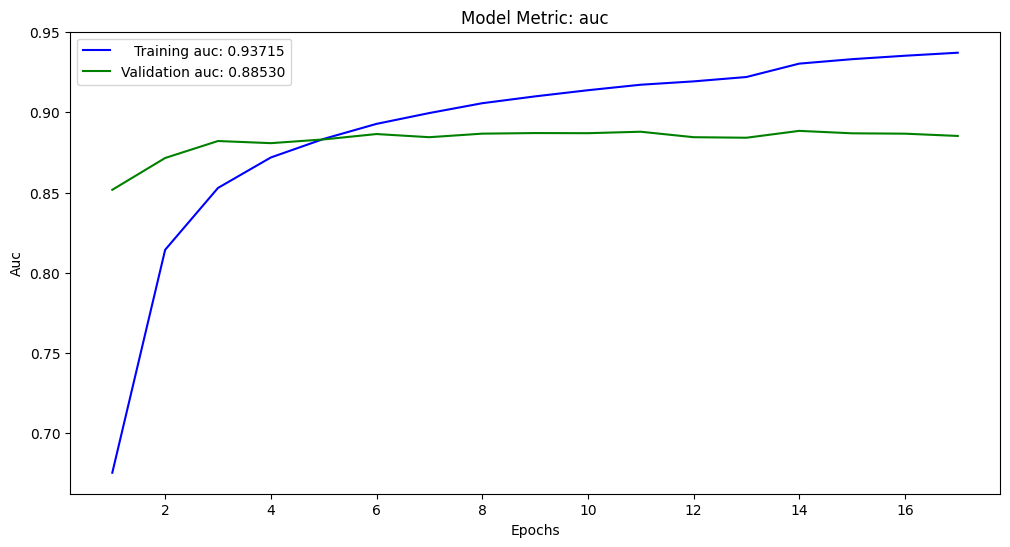

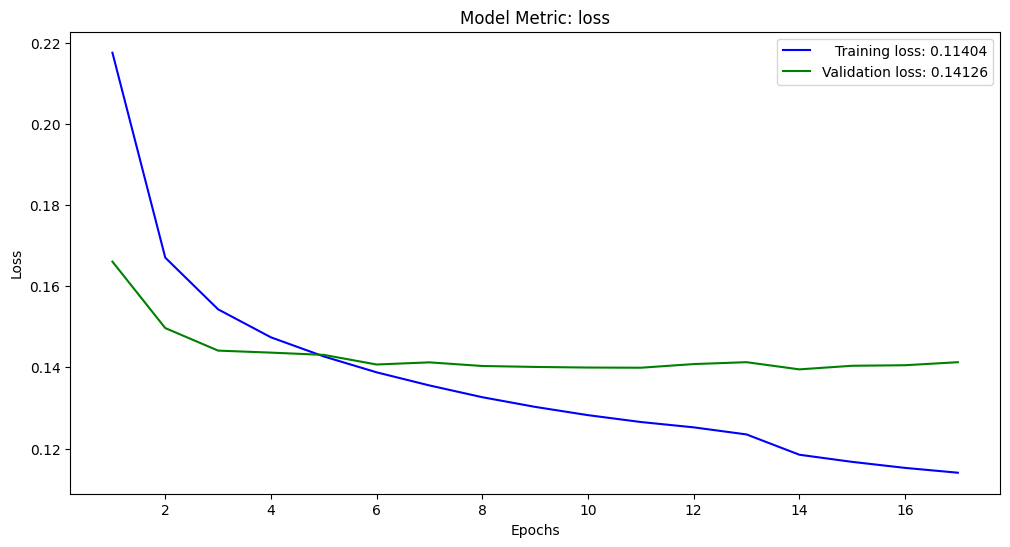

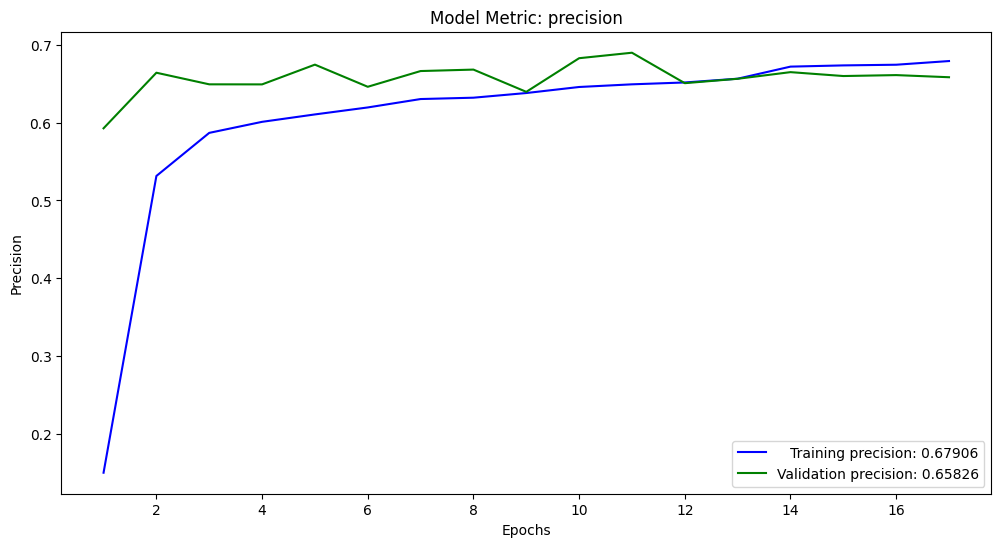

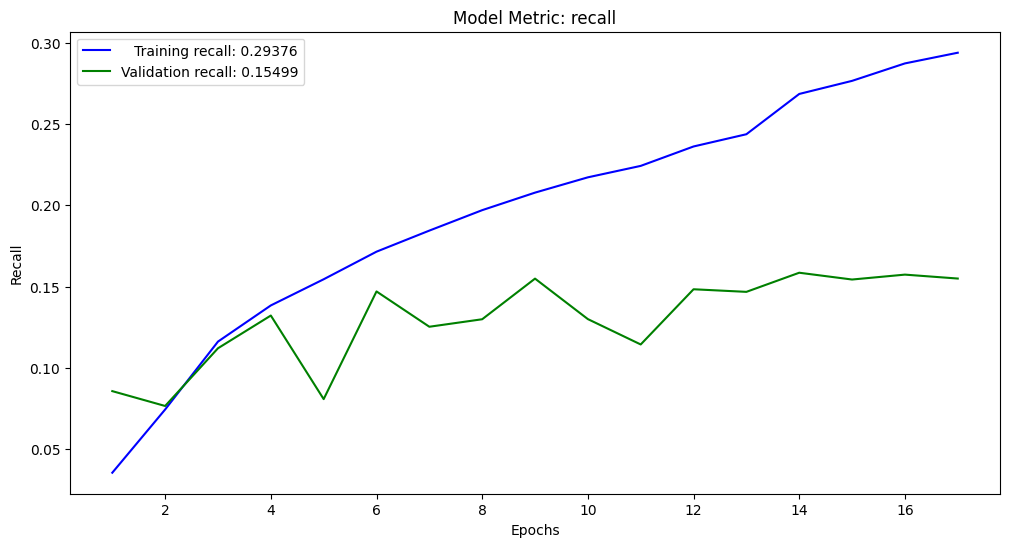

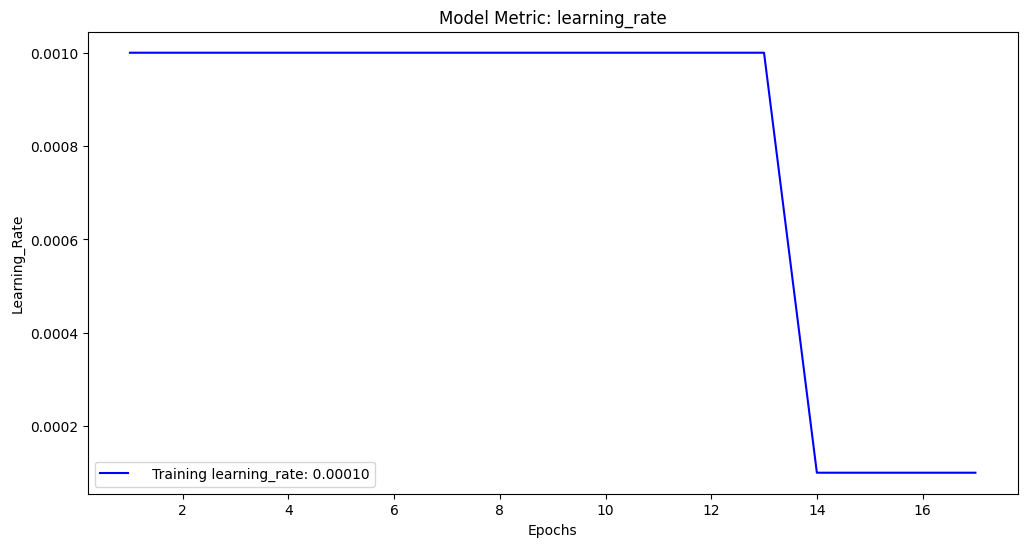

In [ ]:
plot_keras_history(seq_model_history)

* Similarly, to get the metrics plots for the LSTM model, we run this function with input the LSTM model training history object (**lstm_model_history**)

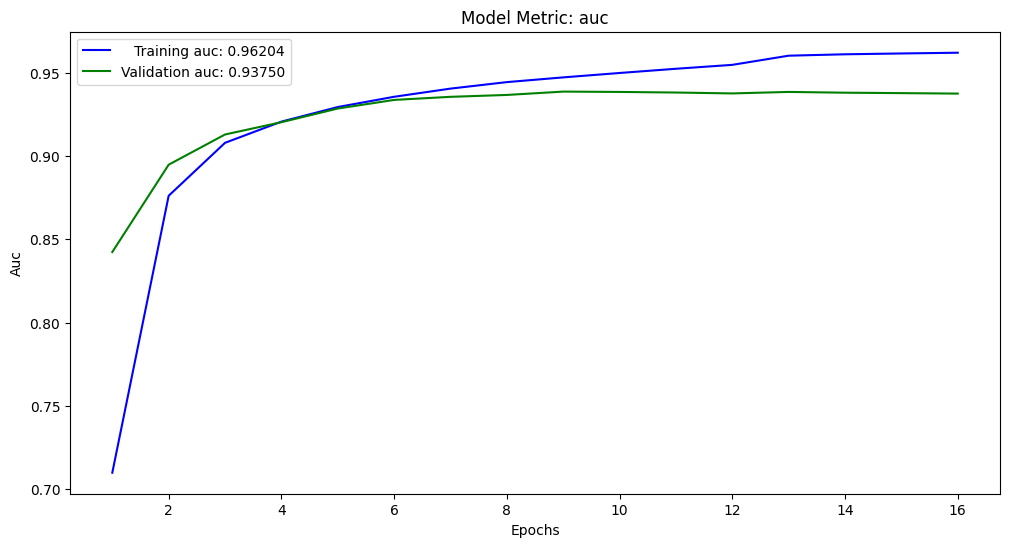

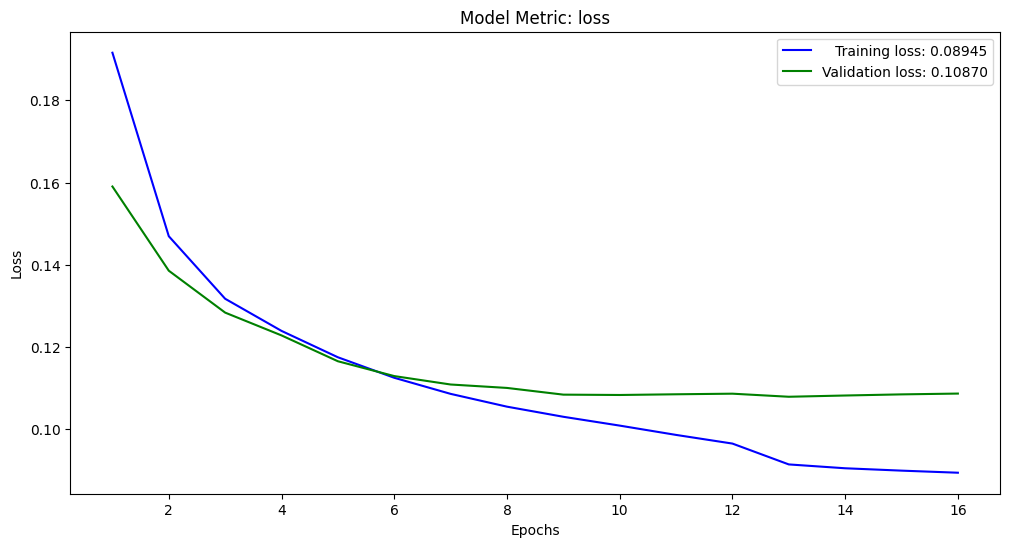

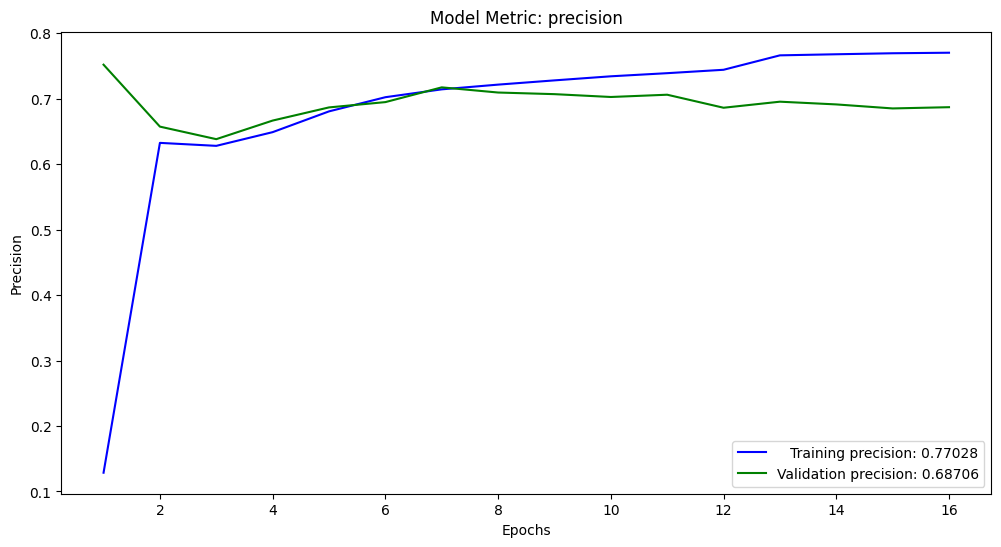

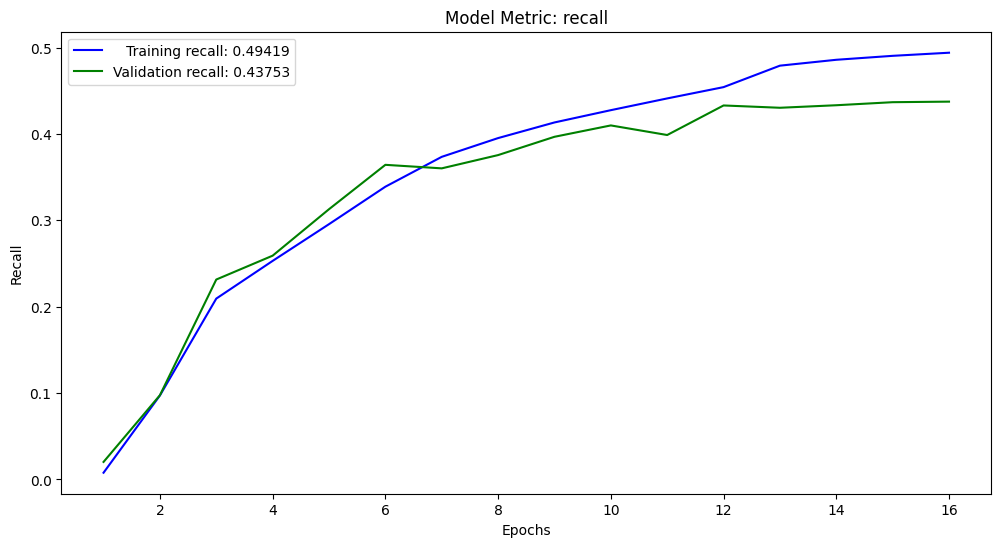

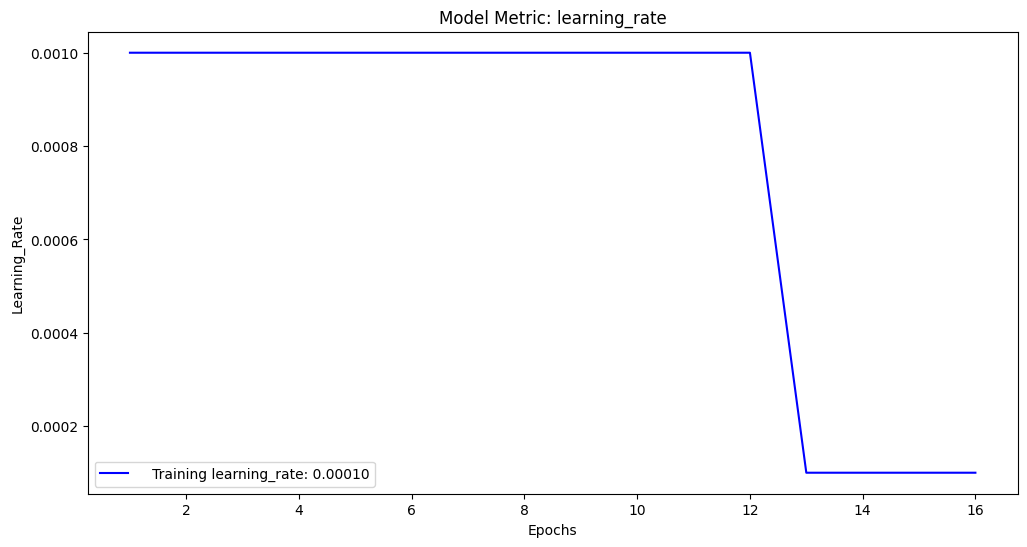

In [ ]:
plot_keras_history(lstm_model_history)

* Following the same logic we define the **plot_distilbert_metrics** function to plot the finetuned DistilBERT's metrics plots:

In [ ]:
def plot_distilbert_metrics(logs_df, metrics=["loss", "accuracy", "precision", "recall", "f1", "auc"]):

    eval_logs = logs_df.dropna(subset=["eval_loss"]).reset_index(drop=True)

    for metric in metrics:
        val_col = f"eval_{metric}"
        if val_col in eval_logs.columns:
            plt.figure(figsize=(8, 5))
            plt.plot(eval_logs["epoch"], eval_logs[val_col], label=f"Validation {metric}", color="green")
            plt.title(f"Validation {metric}")
            plt.xlabel("Epoch")
            plt.ylabel(metric.title())
            plt.legend()
            plt.show()


* Then we extract the training logs of DistilBERT:

In [ ]:
import pandas as pd

# Extract logs
distilbert_logs = trainer.state.log_history

# Convert to DataFrame
distilbert_logs_df = pd.DataFrame(distilbert_logs)


* And call the function:

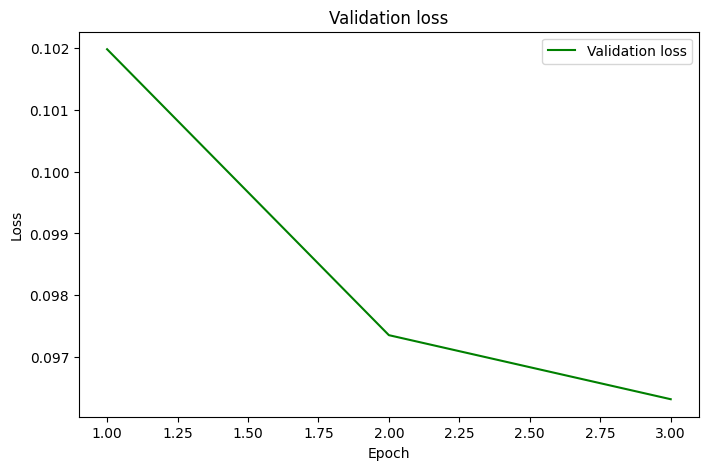

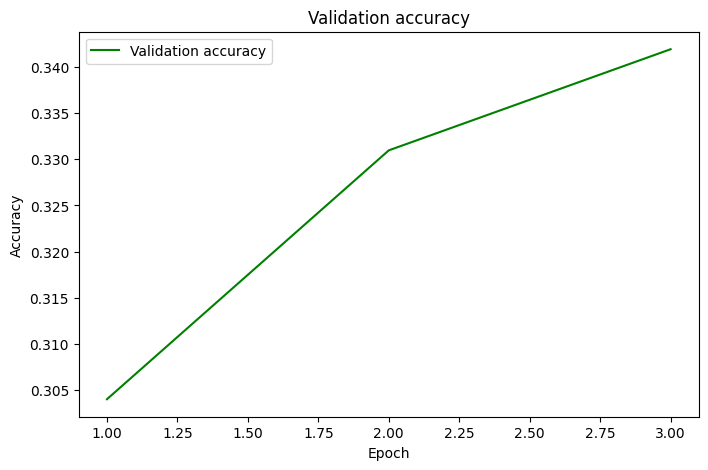

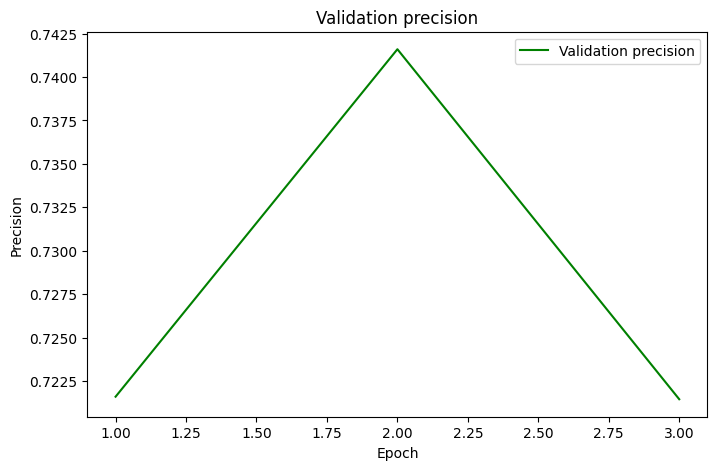

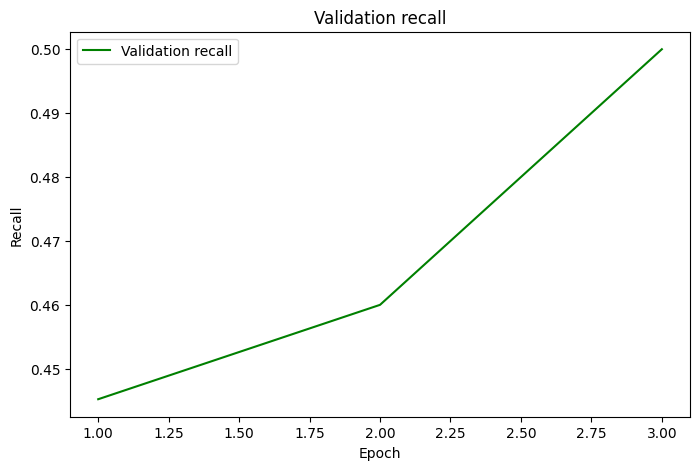

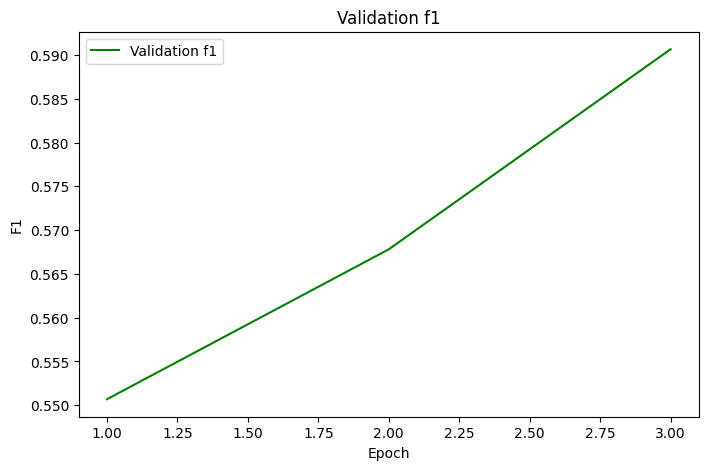

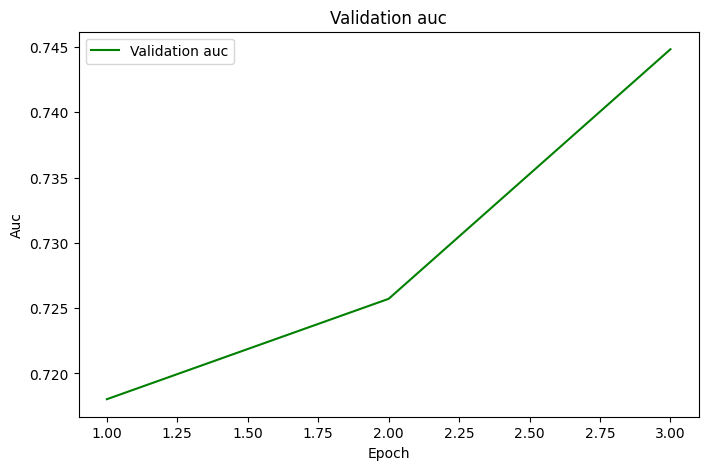

In [ ]:
plot_distilbert_metrics(distilbert_logs_df)

**!! NOTE !!** The plot metrics of DistilBERT appear in strange shapes, because the DistilBERT training was conducted only for 3 epochs (due to recourses limitation).

* EXTRA (for the report & presentation): Plot the tag categories support in the test dataset

In [ ]:
import pandas as pd

y_test_exploded = y_test.explode()

support_counts = y_test_exploded.value_counts()

test_labels_support = support_counts.reset_index()
test_labels_support.columns = ["label", "support"]

test_labels_support = test_labels_support.sort_values(by="support", ascending=True)

only_sequential = [
    "Artificial Intelligence", "Business", "Entrepreneurship", "Life",
    "Life Lessons", "Love", "Marketing", "Relationships",
    "Self", "Self Improvement", "Software Development"
]

test_labels_support["Models Failed"] = test_labels_support["label"].apply(
    lambda x: "All" if x == "Self"
              else "Only Sequential" if x in only_sequential
              else "None"
)


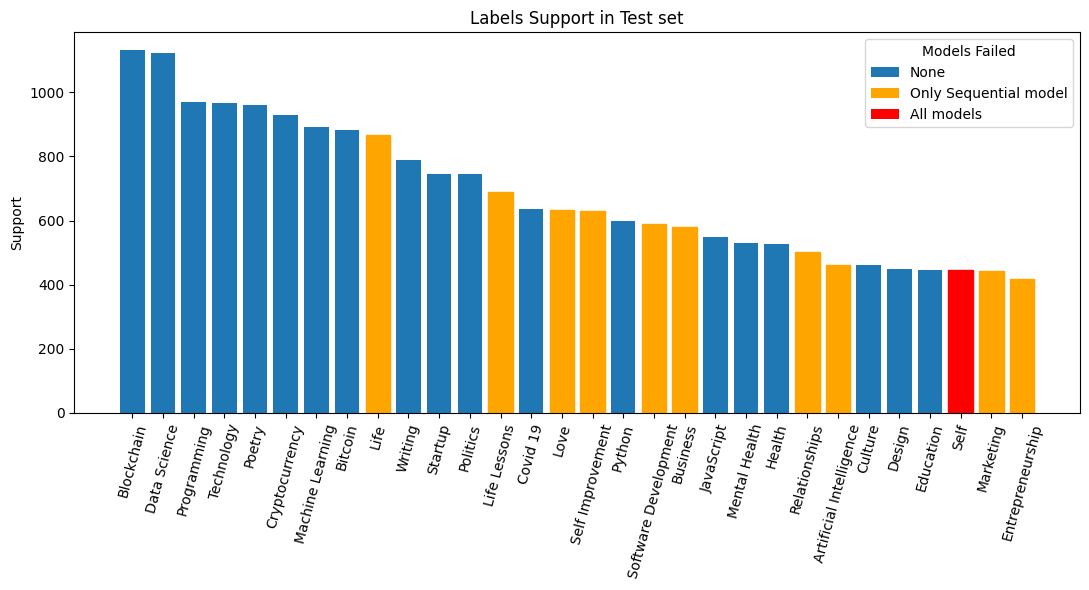

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Sort by support
df_sorted = test_labels_support.sort_values("support", ascending=False)

# Create the plot without assigning colors first
fig, ax = plt.subplots(figsize=(11, 6))
bars = ax.bar(df_sorted["label"], df_sorted["support"])

# Recolor bars depending on Failure value
for bar, failure in zip(bars, df_sorted["Models Failed"]):
    if failure == "Only Sequential":
        bar.set_color("orange")
    elif failure == "All":
        bar.set_color("red")
    # if failure == "None" → keep default

# Add legend with custom colors
legend_elements = [
    Patch(facecolor=bars[0].get_facecolor(), label="None"),
    Patch(facecolor="orange", label="Only Sequential model"),
    Patch(facecolor="red", label="All models")
]
ax.legend(handles=legend_elements, title="Models Failed")

ax.set_ylabel("Support")
ax.set_title("Labels Support in Test set")
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()
